# Experiment 2

Generates all figures, tables, and statistical comparisons for the __Results / Experiment 2__ section

In [22]:
rm(list=ls())

In [23]:
library(dplyr)
library(gtools)
library(ggplot2)
library(binom)
library(BayesFactor)
library(lme4)
library(lmerTest)
library(Hmisc)

## 1. Combining files from individual observers into a single table.
While loading, also marking out individual trials and removing duplicate key presses

In [24]:
all.csv.files <- list.files(path= 'Experiment 2', pattern= '*.csv')
results <- data.frame()

observers.with.extremely.strong.bias <- c('BPM1997w')

for(current.filename in all.csv.files){
    # excluding observer with extreme bias, see spatially specific bias analysis for details
    if (substr(current.filename, 1, nchar(current.filename)-4) %in% observers.with.extremely.strong.bias){
        cat(sprintf('Excluding %s due to extreme perceptual bias\n', substr(current.filename, 1, nchar(current.filename)-4)))      
        next;
    }
    
    current.observer <- read.csv2(normalizePath(paste('Experiment 2', current.filename, sep='/')))
    
    # correcting any rounding errors on the RelativeLocation
    current.observer$RelativeLocation[which(current.observer$RelativeLocation< -1)]<- -1
    current.observer$RelativeLocation[current.observer$RelativeLocation> 1]<-  1
    
   
    # adding trial index (time between two extremeties)
    current.observer$Trial <- NA
    for(current.block in unique(current.observer$Block)){
        iTrialStartEnd <- which((current.observer$Block==current.block) &  
                                 current.observer$Event %in% c('Block start', 'Trajectory limit', 'Block end'))
        
        for(iCurrentTrial in 1:(length(iTrialStartEnd)-1)){
            current.observer$Trial[iTrialStartEnd[iCurrentTrial]:iTrialStartEnd[iCurrentTrial+1]]<- iCurrentTrial
        }
    }
    

    # removing duplicate percepts, i.e. a participant reporting same percept again after the blink
    i.duplicates <- c()
    for(current.block in unique(current.observer$Block)){
        current.percept <- 100 # percept code that is definitely different from anything being reported
        for(i.row in which(current.observer$Block==current.block)){
            if (current.observer$Event[i.row]=='Percept'){
                if (current.percept == current.observer$Value[i.row]){
                    i.duplicates <- c(i.duplicates, i.row)
                }
                current.percept <- current.observer$Value[i.row]
            }
        }
    }
    if (length(i.duplicates)>0){
        current.observer <- current.observer[-i.duplicates, ]
    }        
    
    # binding tables
    results <- rbind(results, current.observer)
}

# being tidy
rm(list=setdiff(ls(), "results"))


# replacing "b" and "y" with "background" and "yellow"
levels(results$Color)[levels(results$Color)=='b'] <- 'background'
levels(results$Color)[levels(results$Color)=='y'] <- 'yellow'

# making yellow to be the fist, so that legend matches color order
results$Color <- relevel(results$Color, "yellow")

Excluding BPM1997w due to extreme perceptual bias


## 2. Computing persistence, as a function of the aperture area (occluder) and visibility (color)

First, we compute number of switches reported when object was __past__ the midpoint, _i.e._ it re-emerged and should either persist (few trials with switches) or not (many trials with switches) and convert it into the P<sub>survival</sub> for each combination of factors. 

In [25]:
# computing whether an event occured before or after the mid-point
results$normalized.location <- results$RelativeLocation*results$Direction
results$after.midpoint <- results$normalized.location>0

# counting post midpoint percept onsets (e.i., switches) for each trial
percepts.per.trial <- results %>%
    dplyr::group_by(Observer, Trial, Occluder, Color) %>%
    dplyr::summarize(percepts.after.midpoint= sum(Event=='Percept' & normalized.location>0.1 & normalized.location<0.4))
percepts.per.trial <- data.frame(percepts.per.trial)

# computing number of trials with at least on post-mid-point switch and total number of trials
percepts.per.observer <- percepts.per.trial %>%
                          dplyr::group_by(Observer, Occluder, Color) %>%
                          dplyr::summarise(
                            trials.with.at.least.one.percept= sum(percepts.after.midpoint>0),
                            trials.with.one.percept= sum(percepts.after.midpoint==1),
                            trial.count= n(),
                            P.switch= trials.with.at.least.one.percept/trial.count)

# logit conversion (for ANOVA)
tiny.correction <- 1e-10
percepts.per.observer$logit.P.switch <- logit(percepts.per.observer$P.switch*(1-2*tiny.correction)+tiny.correction)
percepts.per.observer <- data.frame(percepts.per.observer)

## Computing group averages for each condition, plus a 95% binomial confidence interval from a beta posterior (see `binom.bayes` for details).

In [26]:
switches.per.condition <- percepts.per.observer %>%
    dplyr::group_by(Occluder, Color) %>%
    dplyr::summarise(total.trial.count= sum(trial.count),
                     P.mean= mean(P.switch),
                     P.ci.lower= binom.bayes(round(total.trial.count*mean(P.switch)), total.trial.count)$lower,
                     P.ci.upper= binom.bayes(round(total.trial.count*mean(P.switch)), total.trial.count)$upper)

### Plotting group averages
__Figure 3__ in the manuscript.

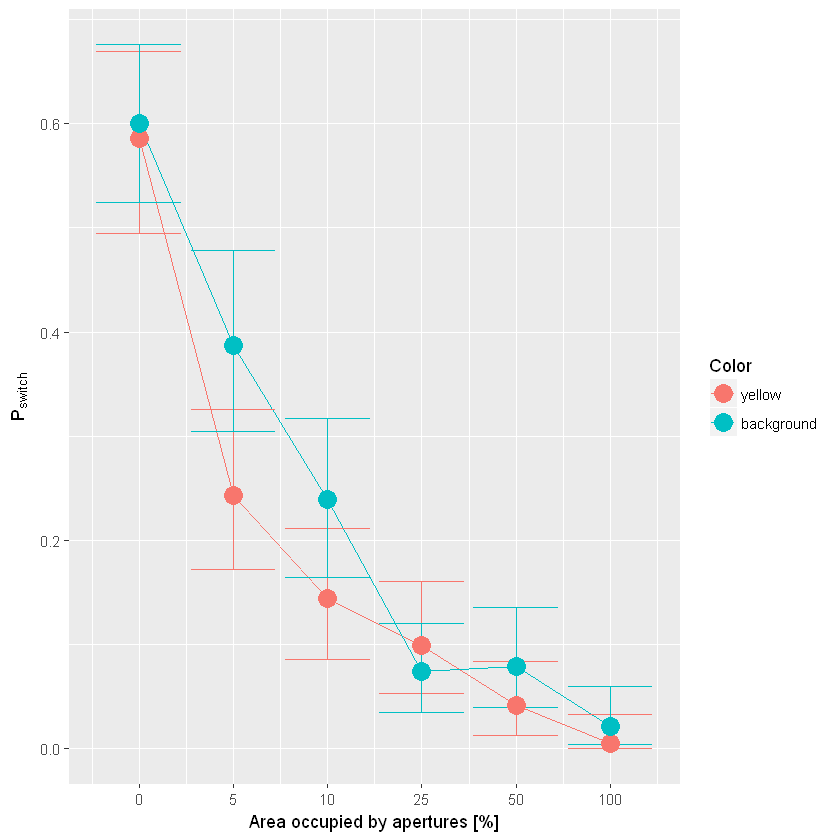

In [27]:
switches.per.condition$i.Occluder <- as.numeric(as.factor(switches.per.condition$Occluder))
survival.plot <- ggplot(switches.per.condition, aes(x= i.Occluder, y= P.mean, ymin=P.ci.lower, ymax= P.ci.upper, 
                                                    color= Color))+
    geom_line()+
    geom_errorbar()+
    geom_point(size= 5)+ 
    xlab("Area occupied by apertures [%]") + ylab(expression(P[switch]))+
    scale_x_continuous(breaks= unique(switches.per.condition$i.Occluder), labels= unique(switches.per.condition$Occluder))
print(survival.plot)
ggsave(file="Generated figures/Experiment 2 - group averages.pdf", plot= survival.plot, width= 12, height= 8, units = 'cm')

### Using `anovaBF` from `BayesFactor` to identify the best model for the data.
Column __Bayes Factor__ of the __Table 2__ in the manuscript.

In [28]:
percepts.per.observer$Occluder <- as.factor(percepts.per.observer$Occluder)
percepts.per.observer$Color <- as.factor(percepts.per.observer$Color)
percepts.per.observer$Observer <- as.factor(percepts.per.observer$Observer)
switches.aov.bf <-   anovaBF(logit.P.switch ~ Occluder * Color + Observer, 
    data= percepts.per.observer,
    whichRandom= 'Observer')
sort(switches.aov.bf, decreasing = TRUE)

Bayes factor analysis
--------------
[1] Occluder + Observer                          : 241137    ±0.43%
[2] Occluder + Color + Observer                  : 152935.1  ±7.12%
[3] Occluder + Color + Occluder:Color + Observer : 18500.82  ±1.06%
[4] Color + Observer                             : 0.4131774 ±0.99%

Against denominator:
  logit.P.switch ~ Observer 
---
Bayes factor type: BFlinearModel, JZS


### Same analysis but using linear mixed models.
__Table 2__ in the manuscript.

In [29]:
percepts.per.observer$Occluder <- as.numeric(as.character(percepts.per.observer$Occluder))

lm.null <- lme4::lmer(P.switch ~ 1 + (1|Observer), data=percepts.per.observer, REML= FALSE)
lm.aperture.area <- update(lm.null, .~. + Occluder)
lm.color <- update(lm.aperture.area, .~. + Color)
lm.interaction <- update(lm.color, .~. + Occluder:Color)
anova(lm.null, lm.aperture.area, lm.color, lm.interaction)
# x<- anova(lm.null, lm.aperture.area, lm.color, lm.interaction)

# x$'Pr(>Chisq)'

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
lm.null,3,46.80730,54.50034,-20.403650,40.80730,NA,NA,NA
lm.aperture.area,4,21.00707,31.26446,-6.503534,13.00707,27.8002315,1,1.345100e-07
lm.color,5,22.12814,34.94988,-6.064071,12.12814,0.8789257,1,3.484961e-01
lm.interaction,6,23.94597,39.33206,-5.972983,11.94597,0.1821763,1,6.695096e-01


[1]           NA 1.345100e-07 3.484961e-01 6.695096e-01

## Computing effect size for the best model that uses only width as a fixed factor

In [30]:
r2.corr.mer <- function(m) {
  lmfit <-  lm(model.response(model.frame(m)) ~ fitted(m))
  summary(lmfit)$r.squared
}
cat(sprintf('Effect size for width-only model R2: %.3f\n', r2.corr.mer(lm.aperture.area)))

Effect size for width-only model R2: 0.397


## 3. Using aperture area as the only fixed factor, comparing each aperture area condition to the maximal visibility condition (100% aperture area, occluder==100). 
This is for the __the visible occluder__. In the manuscript, this is the upper table above the plot in __Figure 3__.

In [31]:
percepts.per.observer$occluder.as.factor <- factor(percepts.per.observer$Occluder, levels=sort(unique(percepts.per.observer$Occluder), decreasing = TRUE))

aperture.levels <- sort(unique(percepts.per.observer$Occluder), decreasing = TRUE)
aperture.labels <- sprintf('%.2f', aperture.levels)
percepts.per.observer$aperture.as.factor <- factor(percepts.per.observer$Occluder, levels= aperture.levels, labels= aperture.labels)

rcontrast<-function(t, df) {
    return (sqrt(t^2/(t^2 + df)))
}


lm.aperture.as.factor <- lmerTest::lmer(P.switch ~ aperture.as.factor + (1|Observer), 
                                        data=percepts.per.observer[percepts.per.observer$Color=='yellow', ])
summary(lm.aperture.as.factor)
coefficients.only <- data.frame(summary(lm.aperture.as.factor)$coefficients)
colnames(coefficients.only) <- c('Estimate', 'Std.Error', 'df', 't.value', 'p.value')
dplyr::mutate(coefficients.only, R.sqr= rcontrast(t.value, df))

Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: P.switch ~ aperture.as.factor + (1 | Observer)
   Data: percepts.per.observer[percepts.per.observer$Color == "yellow",      ]

REML criterion at convergence: 9.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1745 -0.4846 -0.1185  0.4622  2.7322 

Random effects:
 Groups   Name        Variance Std.Dev.
 Observer (Intercept) 0.01225  0.1107  
 Residual             0.04702  0.2168  
Number of obs: 48, groups:  Observer, 8

Fixed effects:
                         Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)              0.005435   0.086076 34.610000   0.063    0.950    
aperture.as.factor50.00  0.036685   0.108423 35.000000   0.338    0.737    
aperture.as.factor25.00  0.094203   0.108423 35.000000   0.869    0.391    
aperture.as.factor10.00  0.138587   0.108423 35.000000   1.278    0.210    
aperture.as.factor5.00   0.237772   0.108423 35.

Estimate,Std.Error,df,t.value,p.value,R.sqr
0.005434783,0.08607585,34.60818,0.06313946,9.500187e-01,0.01073214
0.036684783,0.10842267,35.00001,0.33834975,7.371210e-01,0.05709823
0.094202899,0.10842267,35.00001,0.86884874,3.908490e-01,0.14530358
0.138586957,0.10842267,35.00001,1.27821017,2.095874e-01,0.21118403
0.237771739,0.10842267,35.00001,2.19300764,3.504251e-02,0.34757449
0.579904244,0.10842267,35.00001,5.34855170,5.582026e-06,0.67063108


## 4. Same analysis, but for __invisible occluder__.
In the manuscript, this is the lower table above the plot in __Figure 3__.

In [32]:
lm.aperture.as.factor <- lmerTest::lmer(P.switch ~ aperture.as.factor + (1|Observer), 
                                        data=percepts.per.observer[percepts.per.observer$Color=='background', ])
summary(lm.aperture.as.factor)
coefficients.only <- data.frame(summary(lm.aperture.as.factor)$coefficients)
colnames(coefficients.only) <- c('Estimate', 'Std.Error', 'df', 't.value', 'p.value')
dplyr::mutate(coefficients.only, R.sqr= rcontrast(t.value, df))

Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: P.switch ~ aperture.as.factor + (1 | Observer)
   Data: percepts.per.observer[percepts.per.observer$Color == "background",  
    ]

REML criterion at convergence: 11.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.4450 -0.4525 -0.1261  0.3841  2.4857 

Random effects:
 Groups   Name        Variance Std.Dev.
 Observer (Intercept) 0.01314  0.1146  
 Residual             0.04920  0.2218  
Number of obs: 48, groups:  Observer, 8

Fixed effects:
                        Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)              0.02129    0.08827 34.36000   0.241  0.81088    
aperture.as.factor50.00  0.05772    0.11090 35.00000   0.520  0.60602    
aperture.as.factor25.00  0.05344    0.11090 35.00000   0.482  0.63288    
aperture.as.factor10.00  0.21784    0.11090 35.00000   1.964  0.05747 .  
aperture.as.factor5.00   0.36594    0.11090 35.00000

Estimate,Std.Error,df,t.value,p.value,R.sqr
0.02128623,0.08827429,34.36286,0.2411374,8.108817e-01,0.04110104
0.05771940,0.11090063,35.00001,0.5204606,6.060196e-01,0.08763541
0.05344203,0.11090063,35.00001,0.4818911,6.328830e-01,0.08118557
0.21784420,0.11090063,35.00001,1.9643189,5.747300e-02,0.31511468
0.36594203,0.11090063,35.00001,3.2997291,2.231424e-03,0.48711068
0.57860391,0.11090063,35.00001,5.2173186,8.311318e-06,0.66142540


## 5. Linear mixed models analysis but only for 5% and 10% aperture area to see whether the visibility of the occluding object matters

In [49]:
percepts.per.observer$Occluder <- as.numeric(as.character(percepts.per.observer$Occluder))
stability.5.10 <- percepts.per.observer %>% dplyr::filter(Occluder %in% c(5, 10))

lm.null <- lme4::lmer(P.switch ~ 1 + (1|Observer), data=stability.5.10, REML= FALSE)
lm.aperture.area <- update(lm.null, .~. + Occluder)
lm.color <- update(lm.aperture.area, .~. + Color)
anova(lm.null, lm.aperture.area, lm.color)


r2.corr.mer <- function(m) {
  lmfit <-  lm(model.response(model.frame(m)) ~ fitted(m))
  summary(lmfit)$r.squared
}
lm.color <- update(lm.null, .~. + Color)
cat(sprintf('Effect size for 5%% and 10%% for color only model R2: %.3f\n', r2.corr.mer(lm.color)))

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
lm.null,3,20.57188,24.96909,-7.285939,14.57188,NA,NA,NA
lm.aperture.area,4,20.91412,26.77707,-6.457062,12.91412,1.657756,1,0.1979066
lm.color,5,21.25288,28.58156,-5.626442,11.25288,1.661240,1,0.1974360


Effect size for 5% and 10% for color only model R2: 0.435


## 6. Analysis of exogenous trigger effectiveness. 
This information is reported in the __Methods / Displays__ section in the manuscript.

In [37]:
trigger.effectiveness <- results %>%
    dplyr::group_by(Observer, Block, Trial) %>%
    dplyr::summarize(
        has.trigger= sum(Event=='Reverse rotation')>0,
        report.before.midpoint= sum((Event=='Percept')>0 & (after.midpoint==FALSE))>0
    ) %>%
    dplyr::filter(has.trigger==TRUE) %>%
    dplyr::group_by(Observer) %>%
    dplyr::summarize(
        triggered.fraction= sum(report.before.midpoint)/n()
    )

cat(sprintf('Percentage of trials with an effective exogenous trigger: %.2f±%.2f [%.2f..%.2f] (mean±sd [min..max])\n', 
        mean(trigger.effectiveness$triggered.fraction),
        sd(trigger.effectiveness$triggered.fraction),
        min(trigger.effectiveness$triggered.fraction),
        max(trigger.effectiveness$triggered.fraction)))

trigger.effectiveness

Percentage of trials with an effective exogenous trigger: 0.90±0.10 [0.70..0.97] (mean±sd [min..max])


Observer,triggered.fraction
AZM1990w,0.6959459
CEN2000w,0.7916667
EGN1994m,0.9696970
IKB1995w,0.9680451
PHM1988w,0.9436090
SDA1995M,0.9583333
SKL1994w,0.9659091
UKS1989m,0.9384615
